In [21]:
import pandas as pd

df=pd.read_csv("aqar.csv")

pd.set_option("display.max_columns",None)
df.columns


Index(['id', 'title', 'url', 'price', 'meter_price', 'price_2_payments',
       'price_4_payments', 'price_12_payments', 'rnpl_monthly_price',
       'rent_period', 'area_sqm', 'deed_area', 'num_bedrooms', 'num_bathrooms',
       'num_living_rooms', 'num_kitchens', 'num_rooms', 'floor_level', 'age',
       'furnished', 'duplex', 'zoning', 'ac', 'lift', 'maid_room',
       'driver_room', 'pool', 'basement', 'backyard', 'playground',
       'car_entrance', 'stairs', 'stores', 'wells', 'trees',
       'water_availability', 'electrical_availability',
       'drainage_availability', 'private_roof', 'two_entrances',
       'special_entrance', 'apartment_in_villa', 'street_width',
       'street_direction', 'direction', 'city', 'city_id', 'district',
       'district_id', 'province_id', 'address', 'latitude', 'longitude',
       'category_id', 'category_ga_listing_type',
       'category_ga_property_category', 'category_is_rent', 'category_name',
       'category_en', 'category_plural', 'cate

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'meter_price'}>,
        <Axes: title={'center': 'price_2_payments'}>,
        <Axes: title={'center': 'price_4_payments'}>,
        <Axes: title={'center': 'price_12_payments'}>],
       [<Axes: title={'center': 'rnpl_monthly_price'}>,
        <Axes: title={'center': 'rent_period'}>,
        <Axes: title={'center': 'area_sqm'}>,
        <Axes: title={'center': 'deed_area'}>,
        <Axes: title={'center': 'num_bedrooms'}>,
        <Axes: title={'center': 'num_bathrooms'}>],
       [<Axes: title={'center': 'num_living_rooms'}>,
        <Axes: title={'center': 'num_kitchens'}>,
        <Axes: title={'center': 'num_rooms'}>,
        <Axes: title={'center': 'floor_level'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'zoning'}>],
       [<Axes: title={'center': 'street_width'}>,
        <Axes: title={'center': 'street_direction'}>,
        <Axes:

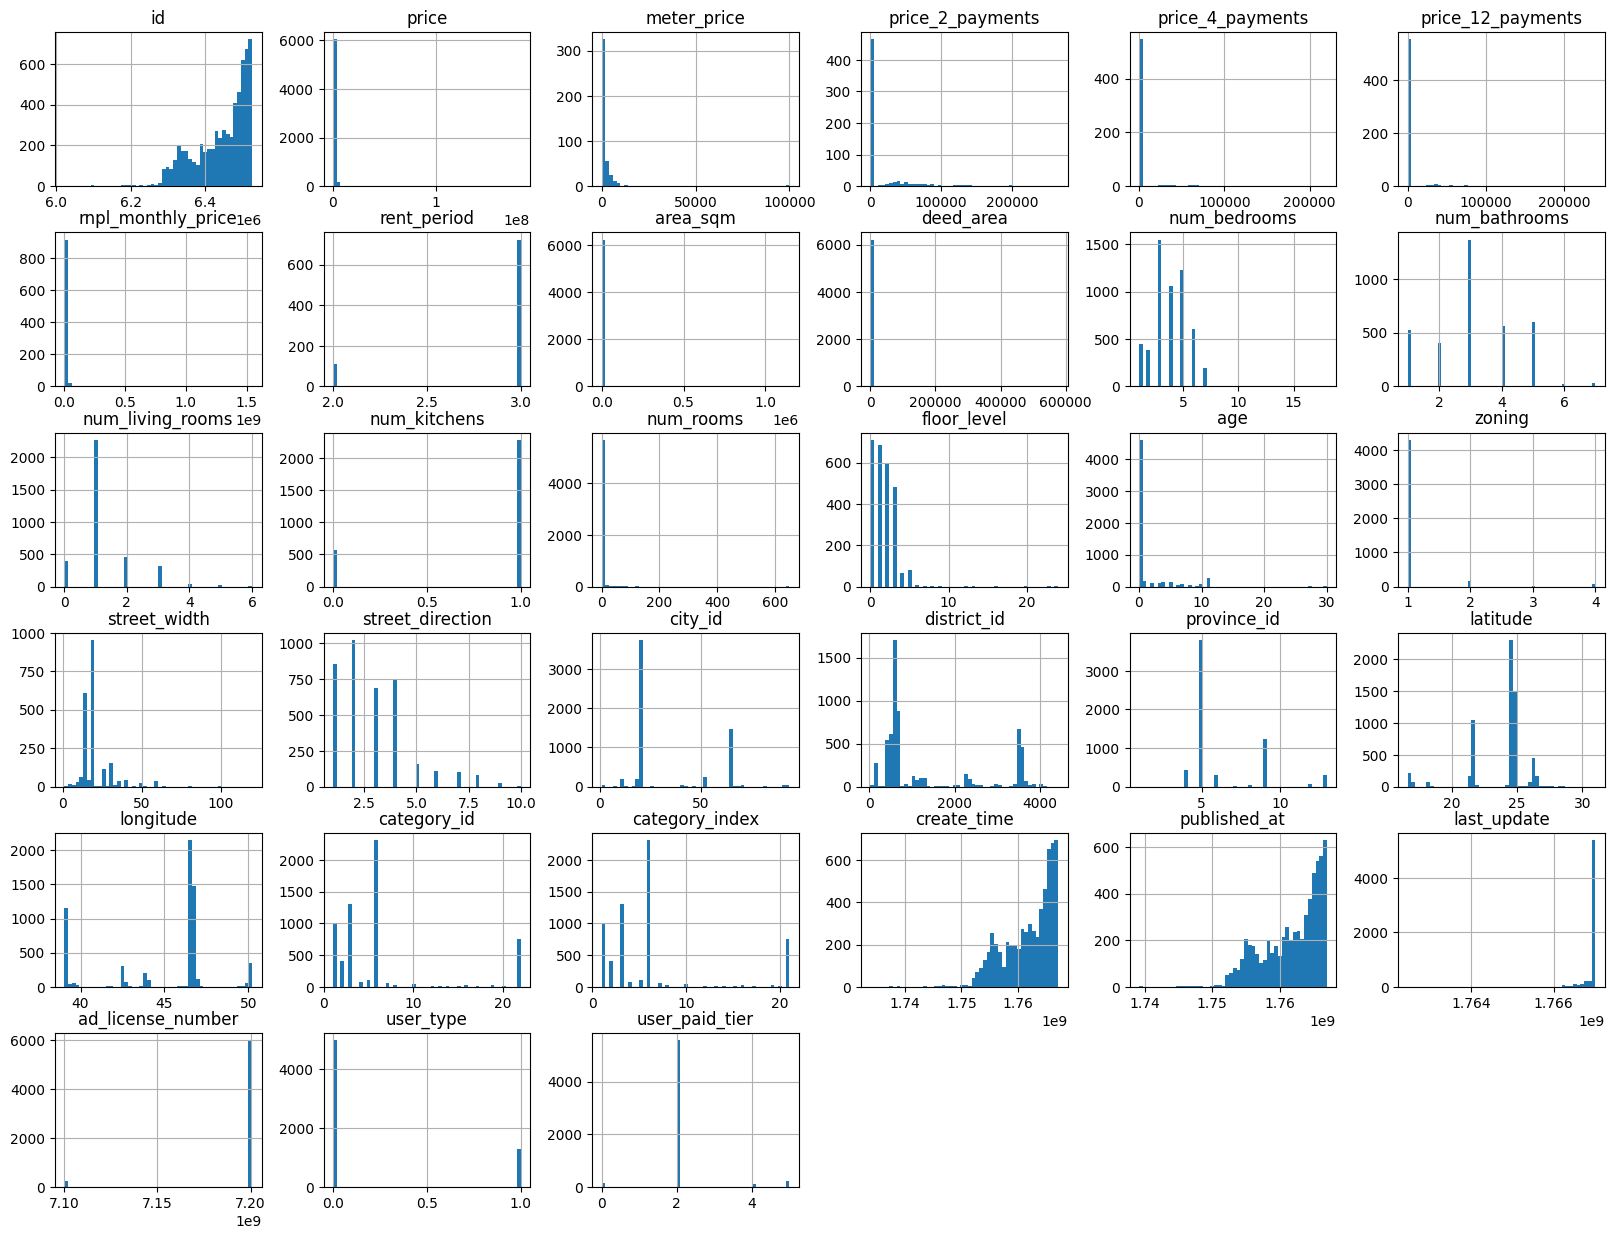

In [22]:
df.hist(bins=50, figsize=(20,15))

In [23]:
# show category_ga_property_category possible values
df['category_ga_property_category'].value_counts()
df[df["district"] == "حي دره المنسك"]

,id,title,url,price,meter_price,price_2_payments,price_4_payments,price_12_payments,rnpl_monthly_price,rent_period,area_sqm,deed_area,num_bedrooms,num_bathrooms,num_living_rooms,num_kitchens,num_rooms,floor_level,age,furnished,duplex,zoning,ac,lift,maid_room,driver_room,pool,basement,backyard,playground,car_entrance,stairs,stores,wells,trees,water_availability,electrical_availability,drainage_availability,private_roof,two_entrances,special_entrance,apartment_in_villa,street_width,street_direction,direction,city,city_id,district,district_id,province_id,address,latitude,longitude,category_id,category_ga_listing_type,category_ga_property_category,category_is_rent,category_name,category_en,category_plural,category_uri,category_path,category_keywords,category_description,category_index,sale_type,is_rental,is_sale,is_auction,is_daily_rental,create_time,published_at,last_update,verified,boosted,premium,has_img,has_video,ad_license_number,deed_number,rega_licensed,plan_no,parcel_no,user_type,user_verified,company_name,user_paid_tier,description,images,videos
3,6495984,"شقه للبيع في شارع الغاير, حي المروج, مدينه ابه...",https://sa.aqar.fm/شقق-للبيع/ابها/حي-دره-المنس...,635000.0,NaN,NaN,NaN,NaN,NaN,NaN,215.0,215.62,6.0,NaN,NaN,NaN,6.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN,4.0,NaN,ابها,1.0,حي دره المنسك,3832.0,12.0,"شارع الغاير, حي المروج, مدينه ابها, منطقه عسير",18.196935,42.556961,6,sale,apartment,False,شقة للبيع,Apartment for sale,شقق للبيع,شقق-للبيع,/شقق-للبيع,"['شقة', 'شقق', 'للبيع']",شقق للبيع بالرياض، جدة، الدمام، مكة، المدينة و...,6,sale,False,True,False,False,1765094406,1765094406,1767012448,True,True,False,True,True,7.200786e+09,760002989199,True,1022 / 1424هـ / ع / 1,499,0,True,مكتب خيال الاركان للعقار,4.0,شقق دوبلكس نظام تاون هاوس للبيع شقق دوبلكس جد...,"['000635467_1765094224978.jpg', '000635463_176...",['000635463_1765094375794']
1754,6484049,"شقه للايجار في شارع ابو هريره, حي المروج, مدين...",https://sa.aqar.fm/شقق-للايجار/ابها/حي-دره-الم...,48000.0,NaN,NaN,NaN,NaN,4280.0,NaN,145.0,145.05,3.0,NaN,NaN,NaN,3.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN,4.0,NaN,ابها,1.0,حي دره المنسك,3832.0,12.0,"شارع ابو هريره, حي المروج, مدينه ابها, منطقه عسير",18.197215,42.565137,1,rent,apartment,True,شقة للإيجار,Apartment for rent,شقق للإيجار,شقق-للإيجار,/شقق-للإيجار,"['شقة', 'شقق', 'للإيجار', 'تأجير', 'أجار']",شقق للايجار بالرياض، جدة، الدمام، مكة، المدينة...,1,rent,True,False,False,False,1764280281,1764280281,1766997789,True,False,False,True,True,7.100238e+09,260002633331,True,5290 / 1444 / ع / 1,16,0,True,موسسه علي يوسف الخالد,0.0,شقه للايجار – ابها | حي دره المنسك الدور الثا...,"['022838241_1764280211399.jpg', '022838248_176...",['022838244_1764280223922']
3239,6496270,"شقه للبيع في شارع الحناء, حي العقيق, مدينه ابه...",https://sa.aqar.fm/شقق-للبيع/ابها/حي-دره-المنس...,500000.0,NaN,NaN,NaN,NaN,NaN,NaN,148.0,148.34,4.0,3.0,1.0,1.0,4.0,1.0,0.0,False,NaN,1.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,True,True,False,True,True,False,NaN,1.0,NaN,ابها,1.0,حي دره المنسك,3832.0,12.0,"شارع الحناء, حي العقيق, مدينه ابها, منطقه عسير",18.199861,42.621527,6,sale,apartment,False,شقة للبيع,Apartment for sale,شقق للبيع,شقق-للبيع,/شقق-للبيع,"['شقة', 'شقق', 'للبيع']",شقق للبيع بالرياض، جدة، الدمام، مكة، المدينة و...,6,sale,False,True,False,False,1765108407,1765108407,1767010850,True,False,False,True,True,7.200787e+09,560002713527,True,2474 / 1437 / ع / 1,168,0,True,موسسه منازل قوت العقاريه,2.0,للبيع شقق نظام ادوار في ابها – مخطط العقيق طري...,"['014872044_1765108282203.jpg', '014872045_176...",['014872046_1765108311169']
3674,6443083,"شقه للبيع في حي الصفاء, مدينه ابها, منطقه عسير",https://sa.aqar.fm/شقق-للبيع/ابها/حي-دره-المنس...,620000.0,NaN,NaN,NaN,NaN,NaN,NaN,237.0,237.29,5.0,NaN,NaN,NaN,5.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN,3.

In [24]:
num_feature_cols=["area_sqm","num_bedrooms","num_bathrooms"]
cat_feature_cols=["district","city"]
bool_feature_cols=["pool","maid_room","driver_room","ac","lift"]

df = df[(df['is_rental'] == False) & (df['is_daily_rental'] == False) & (df['sale_type'] != 'rent') & (df['sale_type'] !='daily')].copy()

pd.set_option('future.no_silent_downcasting', True)
df[bool_feature_cols] = df[bool_feature_cols].fillna(False)
# drop listings of land without buildings
df=df[df['category_ga_property_category'] != 'land'].copy()
# drop listings of commercial buildings
df=df[(df["category_ga_listing_type"]!= "office") & (df["category_ga_listing_type"]!="store") & (df["category_ga_listing_type"]!="warehouse") & (df["category_ga_listing_type"]!="lounge")].copy()
target_col=["price"]

df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col].head()


,area_sqm,num_bedrooms,num_bathrooms,district,city,pool,maid_room,driver_room,ac,lift,price
0,116.0,4.0,3.0,حي النرجس,الرياض,False,False,False,False,False,1500000.0
1,700.0,7.0,5.0,حي الملقا,الرياض,False,True,True,False,True,13500000.0
3,215.0,6.0,NaN,حي دره المنسك,ابها,False,False,False,False,False,635000.0
4,169.0,5.0,NaN,حي ابها الجديده,ابها,False,False,False,False,False,510000.0
5,208.0,6.0,NaN,حي القريقر,ابها,False,False,False,False,False,540000.0


In [25]:
from sklearn.model_selection import train_test_split

# Drop rows with missing values in the selected columns
df = df.dropna(subset=num_feature_cols + cat_feature_cols + bool_feature_cols + target_col)

# One-hot encode the categorical columns (district and city)
df_encoded = pd.get_dummies(df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col], columns=cat_feature_cols, drop_first=True)

# Define features and target
X = df_encoded.drop(columns=target_col)
y = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print("\nCoefficients:", model.coef_)
print("Intercept:", model.intercept_)


Mean Squared Error: 316100395851.4754
R^2 Score: 0.5664373173573949

Coefficients: [[ 1.47016609e+03  1.27502141e+05  8.28361491e+04  1.58415601e+06
   3.18448544e+05  1.07556220e+06  1.71270221e-06 -7.49250833e+04
  -2.50240113e+05  6.45989164e+05  1.57959082e+05  1.72845866e+06
   1.43334382e+06  7.00289393e+05 -3.33235536e+05  5.48913687e+05
   3.80438893e+05  1.14235366e+05  1.34148602e+06  9.95230122e+05
   7.57673790e+05  1.95459678e+06  1.08720017e+06  8.08845696e+05
   6.32484809e+05  2.94456099e+05  1.17411802e+06  3.15438699e+05
   3.09116022e+05  1.13854185e-07  1.33644789e-07  9.38118322e+05
   1.13514691e+06  2.91186824e+05  1.42072806e+04 -4.82261767e+05
   8.79392989e+05  1.62507135e+06  3.44666729e+05 -1.44134579e+06
   5.97314685e+05  1.07332915e+06  7.17178825e+05  5.37772707e+06
   7.95418488e+05  9.59771639e+05  9.41104282e+05  6.85021448e+05
   7.25352893e+05  1.91651348e+06 -2.45743760e+05  9.94018027e+05
   4.36702097e+05  4.89093038e+05 -2.04890966e-08  8.280543

In [27]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train.values.ravel())
y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R^2 Score: {r2_rf}")

Random Forest Mean Squared Error: 232795395084.04114
Random Forest R^2 Score: 0.680698292934419


In [28]:
cross_val_scores = cross_val_score(model, X, y.values.ravel(), cv=5, scoring='r2')
print(f"Cross-validated R^2 scores: {cross_val_scores}")
print(f"Average Cross-validated R^2 score: {cross_val_scores.mean()}")

cross_val_scores_rf = cross_val_score(model_rf, X, y.values.ravel(), cv=5, scoring='r2')
print(f"Random Forest Cross-validated R^2 scores: {cross_val_scores_rf}")
print(f"Random Forest Average Cross-validated R^2 score: {cross_val_scores_rf.mean()}")


Cross-validated R^2 scores: [0.59406949 0.48377186 0.62828048 0.25031681 0.54733333]
Average Cross-validated R^2 score: 0.5007543915579568
Random Forest Cross-validated R^2 scores: [0.56176771 0.66116097 0.78125385 0.49567627 0.62378706]
Random Forest Average Cross-validated R^2 score: 0.6247291721961631
